# Kaggle - NLP with Disaster Tweets

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
np.random.seed(0)
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import regularizers
np.random.seed(1)
from sklearn.model_selection import train_test_split

In [295]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
print('Training Set Shape: {} \nTest Set Shape: {}'.format(train_df.shape, test_df.shape))

Training Set Shape: (7613, 5) 
Test Set Shape: (3263, 4)


In [4]:
ntrain = 7613

In [5]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [263]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [264]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [272]:
'''train_df.keyword.replace('%20', ' ', inplace = True)
test_df.keyword.replace('%20', ' ', inplace = True)
train_df.fillna('', inplace=True)
test_df.fillna('', inplace=True)

train_df.text = train_df.text + train_df.keyword
test_df.text = test_df.text + test_df.keyword'''

In [296]:
X = np.array(train_df['text'])
Y = np.array(train_df['target'])
X_test = np.array(test_df['text'])

In [275]:
import re
import string


def remove_urls(tweet):
    return re.sub(r"http(s?)://[\S]+", '', tweet)

def remove_at_links(tweet):
    return re.sub(r"\B(@)\S+", '', tweet)

def remove_non_ascii_chars(tweet):
    ascii_chars = set(string.printable)
    for c in tweet:
        if c not in ascii_chars:
            tweet = tweet.replace(c,'')
    return tweet

def fix_ax_nots(tweet):
    tweet = tweet.replace(" dont ", " do not ")
    tweet = tweet.replace(" don't ", " do not ")
    tweet = tweet.replace(" doesnt ", " does not ")
    tweet = tweet.replace(" doesn't ", " does not ")
    tweet = tweet.replace(" wont ", " will not ")
    tweet = tweet.replace(" won't ", " will not ")
    tweet = tweet.replace(" cant ", " cannot ")
    tweet = tweet.replace(" can't ", " cannot ")
    tweet = tweet.replace(" couldnt ", " could not ")
    tweet = tweet.replace(" couldn't ", " could not ")
    tweet = tweet.replace(" shouldnt ", " should not ")
    tweet = tweet.replace(" shouldn't ", " should not ")
    tweet = tweet.replace(" wouldnt ", " would not ")
    tweet = tweet.replace(" wouldn't ", " would not ")
    tweet = tweet.replace(" mustnt ", " must not ")
    tweet = tweet.replace(" mustn't ", " must not ")
    
    return tweet

def fix_personal_pronouns_and_verb(tweet):
    tweet = tweet.replace(" im ", " i am ")
    tweet = tweet.replace(" youre ", " you are")
    tweet = tweet.replace(" hes ", " he is") # ? he's can be he has as well
    tweet = tweet.replace(" shes ", " she is")
    # we are -> we're -> were  ---- were is a valid word
    tweet = tweet.replace(" theyre ", " they are")
    
    tweet = tweet.replace(" ive ", " i have ")
    tweet = tweet.replace(" youve ", " you have ")
    tweet = tweet.replace(" weve ", " we have ")
    tweet = tweet.replace(" theyve ", " they have ")
    
    tweet = tweet.replace(" youll ", " you will ")
    tweet = tweet.replace(" theyll ", " they will ")
    
    return tweet

def fix_special_chars(tweet):
    tweet = tweet.replace("&amp;", " and ")
    # tweet = tweet.replace("--&gt;", "")
    return tweet
        

def clean_tweet(tweet):
    tweet = remove_urls(tweet)
    tweet = remove_at_links(tweet)
    tweet = remove_non_ascii_chars(tweet)
    tweet = fix_special_chars(tweet)
    tweet = fix_ax_nots(tweet)
    tweet = fix_personal_pronouns_and_verb(tweet)
        
    return tweet

In [297]:
X = np.array([clean_tweet(tweet) for tweet in X])
X_test = np.array([clean_tweet(tweet) for tweet in X_test])

In [298]:
maxLen_train = maxLen_test = 0
for sentence in X_test:
    Len = len(sentence.split())
    maxLen_train = max(maxLen, Len)

for sentence in X_test:
    Len = len(sentence.split())
    maxLen_test = max(maxLen, Len)
    
maxLen = max(maxLen_test, maxLen_train)
maxLen

32

In [30]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [31]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [43]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        #print(len(sentence_words))
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                #print(j)
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j += 1
            
    
    return X_indices

In [34]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = emb_dim, trainable = False)

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [301]:
def disasterTweets(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=(input_shape), dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices) 
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 64, return_sequences = True, kernel_regularizer = regularizers.L2(0.01))(embeddings)
    # Add dropout
    X = Dropout(rate=0.5)(X) 
    # The returned output should be a batch of sequences.
    X = Bidirectional(LSTM(units = 64, return_sequences=True, kernel_regularizer = regularizers.L2(0.01)))(X)
    # Add dropout
    X = Dropout(rate=0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units = 128, return_sequences = False, kernel_regularizer = regularizers.L2(0.01))(X)
    # Add dropout
    X = Dropout(rate=0.5)(X)
    # Propagate X through a Dense layer with 1 units
    X = Dense(1)(X)
    # Add a sigmoid activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)
    
    
    return model

In [302]:
model = disasterTweets((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 32, 50)            20000050  
_________________________________________________________________
lstm_37 (LSTM)               (None, 32, 64)            29440     
_________________________________________________________________
dropout_30 (Dropout)         (None, 32, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 128)           66048     
_________________________________________________________________
dropout_31 (Dropout)         (None, 32, 128)           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 128)             

In [303]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [304]:
#X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.10, random_state=16)

In [305]:
#print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
print(X.shape, Y.shape)

(7613,) (7613,)


In [306]:
#X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_indices = sentences_to_indices(X, word_to_index, maxLen)

In [321]:
callback = EarlyStopping(monitor='accuracy', patience=50)
history1 = model.fit(X_indices, Y, epochs = 30, shuffle=True, validation_split = 0.05, batch_size = 128, callbacks=[callback])

Epoch 1/30
57/57 [==============================] - 9s 166ms/step - loss: 0.4272 - accuracy: 0.8269 - val_loss: 0.5030 - val_accuracy: 0.7743
Epoch 2/30
57/57 [==============================] - 10s 167ms/step - loss: 0.4270 - accuracy: 0.8269 - val_loss: 0.4995 - val_accuracy: 0.7953
Epoch 3/30
57/57 [==============================] - 9s 166ms/step - loss: 0.4267 - accuracy: 0.8265 - val_loss: 0.5100 - val_accuracy: 0.7717
Epoch 4/30
57/57 [==============================] - 10s 170ms/step - loss: 0.4319 - accuracy: 0.8223 - val_loss: 0.5258 - val_accuracy: 0.7769
Epoch 5/30
57/57 [==============================] - 10s 168ms/step - loss: 0.4269 - accuracy: 0.8310 - val_loss: 0.5355 - val_accuracy: 0.7717
Epoch 6/30
57/57 [==============================] - 10s 176ms/step - loss: 0.4265 - accuracy: 0.8247 - val_loss: 0.5226 - val_accuracy: 0.7848
Epoch 7/30
57/57 [==============================] - 10s 175ms/step - loss: 0.4286 - accuracy: 0.8284 - val_loss: 0.5397 - val_accuracy: 0.7717
E

In [322]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10)))
model2.add(Bidirectional(LSTM(10)))
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [323]:
callback = EarlyStopping(monitor='accuracy', patience=50)
history2 = model.fit(X_indices, Y, epochs = 30, shuffle=True, validation_split = 0.05, batch_size = 128, callbacks=[callback])

Epoch 1/30
57/57 [==============================] - 12s 204ms/step - loss: 0.4039 - accuracy: 0.8438 - val_loss: 0.5716 - val_accuracy: 0.7822
Epoch 2/30
57/57 [==============================] - 12s 207ms/step - loss: 0.3932 - accuracy: 0.8523 - val_loss: 0.5880 - val_accuracy: 0.7638
Epoch 3/30
57/57 [==============================] - 15s 257ms/step - loss: 0.3975 - accuracy: 0.8469 - val_loss: 0.6065 - val_accuracy: 0.7664
Epoch 4/30
57/57 [==============================] - 13s 223ms/step - loss: 0.3930 - accuracy: 0.8485 - val_loss: 0.5976 - val_accuracy: 0.7717
Epoch 5/30
57/57 [==============================] - 12s 218ms/step - loss: 0.3876 - accuracy: 0.8538 - val_loss: 0.5880 - val_accuracy: 0.7690
Epoch 6/30
57/57 [==============================] - 12s 217ms/step - loss: 0.3963 - accuracy: 0.8527 - val_loss: 0.5814 - val_accuracy: 0.7769
Epoch 7/30
57/57 [==============================] - 13s 221ms/step - loss: 0.3918 - accuracy: 0.8545 - val_loss: 0.6076 - val_accuracy: 0.7664

Model 1:
Training Accuracy:0.8477599620819092 
Validation Accuracy:0.7926509380340576

Model 2:
Training Accuracy:0.8781803250312805 
Validation Accuracy:0.7585301995277405


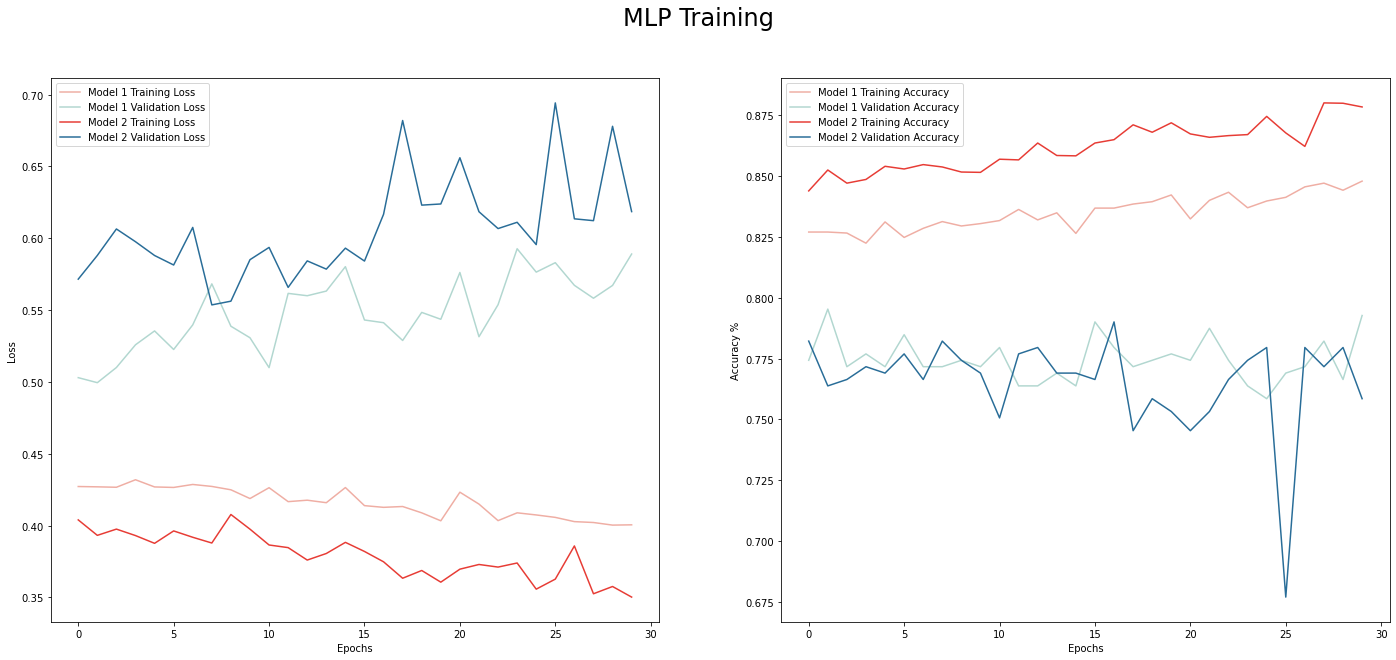

In [324]:
'''plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'],color='#EFAEA4',label = 'Training Loss')
plt.plot(history.history['accuracy'],color='#B2D7D0',label = 'Training Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy %')
plt.title('MLP Training', fontsize = 24);
print('Training Accuracy:{}'.format(history.history['accuracy'][-1]))'''
fig, ax = plt.subplots(1,2,figsize = (24,10))
ax[0].plot(history1.history['loss'],color='#EFAEA4',label = 'Model 1 Training Loss')
ax[0].plot(history1.history['val_loss'],color='#B2D7D0',label = 'Model 1 Validation Loss')
ax[1].plot(history1.history['accuracy'],color='#EFAEA4',label = 'Model 1 Training Accuracy')
ax[1].plot(history1.history['val_accuracy'],color='#B2D7D0',label = 'Model 1 Validation Accuracy')

ax[0].plot(history2.history['loss'],color='#E73C35',label = 'Model 2 Training Loss')
ax[0].plot(history2.history['val_loss'],color='#296D98',label = 'Model 2 Validation Loss')
ax[1].plot(history2.history['accuracy'],color='#E73C35',label = 'Model 2 Training Accuracy')
ax[1].plot(history2.history['val_accuracy'],color='#296D98',label = 'Model 2 Validation Accuracy')

ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('MLP Training', fontsize = 24)

print('Model 1:')
print('Training Accuracy:{} \nValidation Accuracy:{}'.format(history1.history['accuracy'][-1], history1.history['val_accuracy'][-1]))
print('\nModel 2:')
print('Training Accuracy:{} \nValidation Accuracy:{}'.format(history2.history['accuracy'][-1], history2.history['val_accuracy'][-1]))

In [231]:
'''_, X_val, _, Y_val = train_test_split(X, Y, test_size = 0.10, random_state=32)
X_val_indices = sentences_to_indices(X_val, word_to_index, max_len = maxLen)
loss, acc = model.evaluate(X_val_indices, Y_val)
print()
print("Validation Set accuracy = ", acc)'''

24/24 [==============================] - 0s 12ms/step - loss: 0.4564 - accuracy: 0.8189

Validation Set accuracy =  0.8188976645469666


In [325]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
pred = model.predict(X_test_indices)

In [326]:
submission1 = pd.read_csv('sample_submission.csv')

In [327]:
submission1.target = pred

In [328]:
submission1.target = submission1.target.apply(lambda x: round(x))

In [329]:
submission1.to_csv('submission5.csv', index=False)